## Setup and Data Prep

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset


full_dataset = SurrealTrainDataset('/home/s94zalek/shape_matching/data/SURREAL_full/incomplete_datasets/125_125_250_0_28')

# select 90% of the dataset for training and 10% for validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

print(f'Training dataset size: {train_size}', f'Validation dataset size: {val_size}')

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

train_dataset[0][0].shape, train_dataset[0][1].shape

Fmap dim: 28
Training dataset size: 56250 Validation dataset size: 6250


(torch.Size([1, 28, 28]), torch.Size([1, 28]))

Random indices: [55673 47556 16971]
Shape of fmap/eval: torch.Size([1, 28, 28]) torch.Size([1, 28])
Min/max of fmap at index 1: tensor(-1.) tensor(1.)
Min/max of fmap at index 2: tensor(-1.) tensor(1.)


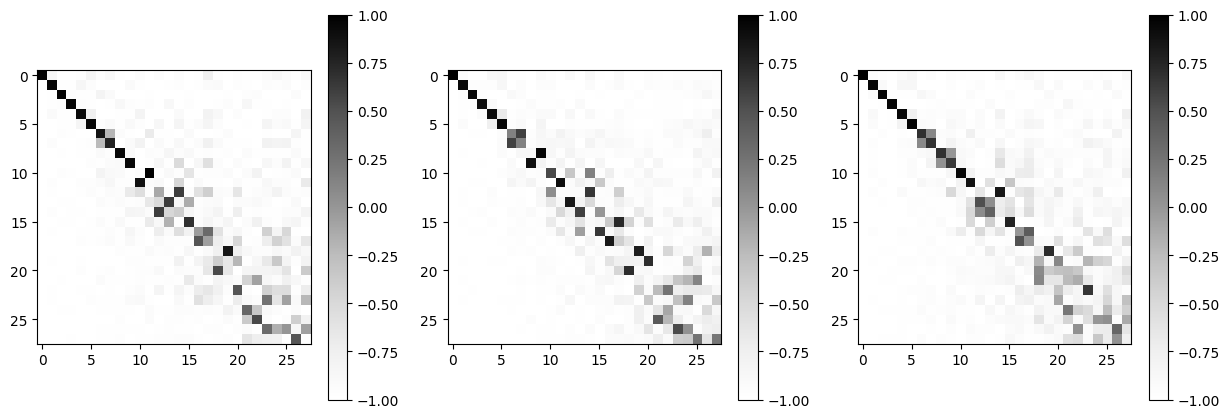

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rand_idx = np.random.randint(0, len(train_dataset), 3)
print('Random indices:', rand_idx)

print('Shape of fmap/eval:', train_dataset[rand_idx[0]][0].shape, train_dataset[rand_idx[0]][1].shape)
print('Min/max of fmap at index 1:', train_dataset[rand_idx[1]][0][0].min(), train_dataset[rand_idx[1]][0][0].max())
print('Min/max of fmap at index 2:', train_dataset[rand_idx[2]][0][0].min(), train_dataset[rand_idx[2]][0][0].max())

ax_0 = ax[0].imshow(train_dataset[rand_idx[0]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(train_dataset[rand_idx[1]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(train_dataset[rand_idx[2]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_2, ax=ax[2])

plt.show()

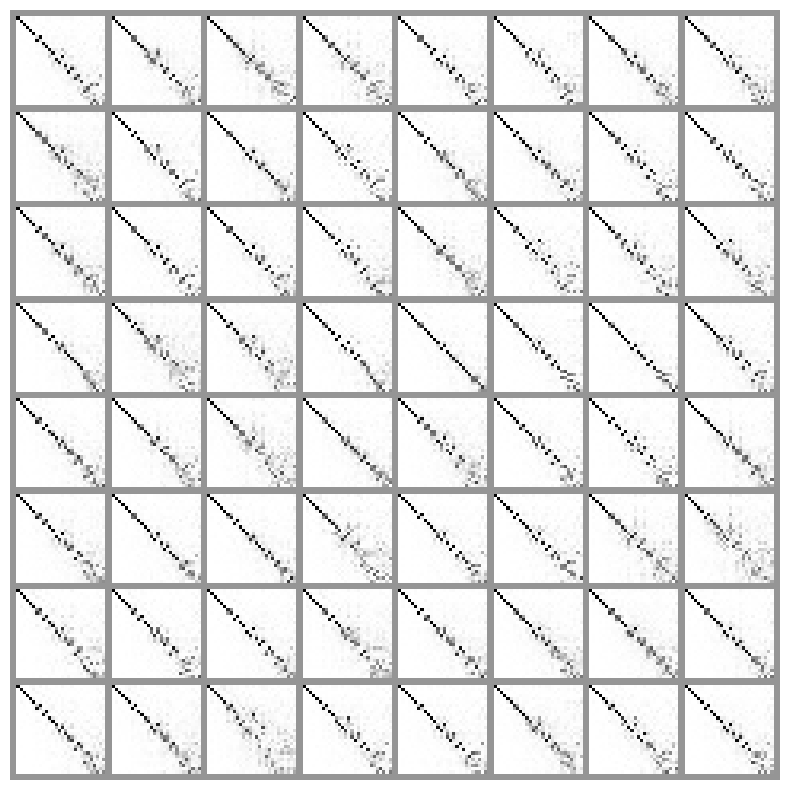

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(torchvision.utils.make_grid(
    torch.stack([train_dataset[i][0] for i in range(64)]),
    nrow=8, value_range=(-1, 1)
    )[0], cmap='Greys')
# disable the axis
ax.axis('off')
plt.show()

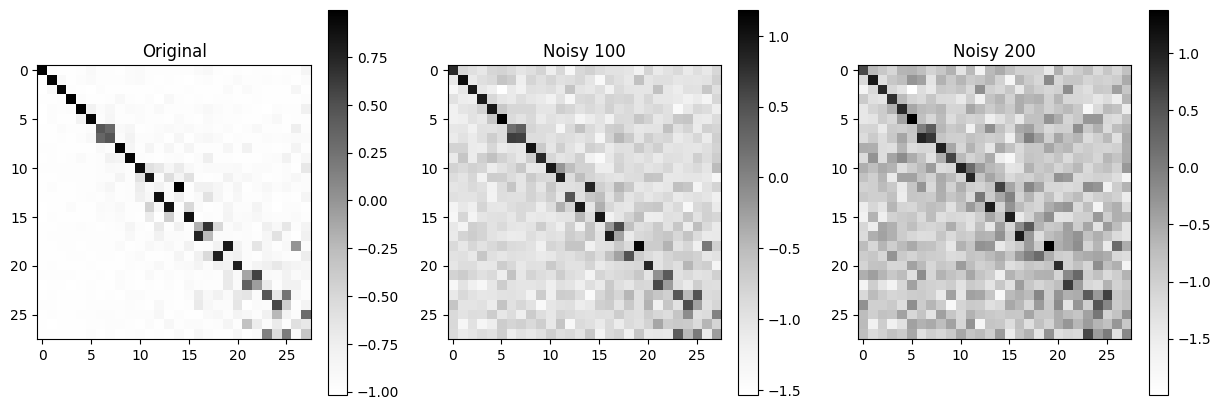

In [5]:
# add noise
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True)

rand_idx = np.random.randint(0, len(train_dataset), 1)
rand_fmap = train_dataset[rand_idx[0]][0]

noise = torch.randn_like(rand_fmap)
timesteps = torch.tensor([0, 100, 200]).long()
noisy_fmap = noise_scheduler.add_noise(rand_fmap, noise, timesteps)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax_0 = ax[0].imshow(noisy_fmap[0], cmap='Greys')
plt.colorbar(ax_0, ax=ax[0])
ax[0].set_title('Original')

ax_1 = ax[1].imshow(noisy_fmap[1], cmap='Greys')
plt.colorbar(ax_1, ax=ax[1])
ax[1].set_title(f'Noisy {timesteps[1]}')

ax_2 = ax[2].imshow(noisy_fmap[2], cmap='Greys')
plt.colorbar(ax_2, ax=ax[2])
ax[2].set_title(f'Noisy {timesteps[2]}')

plt.show()

In [ ]:
def train(model, n_epochs, loss_fn, is_unconditional, train_dataloader, noise_scheduler):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # The optimizer
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Keeping a record of the losses for later viewing
    losses = []

    iterator = tqdm(range(n_epochs))
    # The training loop
    for epoch in iterator:
        for x, y in train_dataloader:

            # Unpack the batch
            x = x.to(device) 
            y = y.to(device)
            
            # sample the noise and the timesteps
            noise = torch.randn_like(x)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (x.shape[0],)).long().to(device)
            
            # Add the noise to the input
            noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

            # Get the model prediction
            if is_unconditional:
                pred = model(sample=noisy_x, timestep=timesteps).sample
            else:
                pred = model(sample=noisy_x, timestep=timesteps, conditioning=y).sample

            # Calculate the loss
            loss = loss_fn(pred, noise) # How close is the output to the noise

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print out the average of the last 100 loss value
        avg_loss = sum(losses[-100:])/100
        iterator.set_postfix({'avg_loss': avg_loss})

    return model, losses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [14:05<00:00, 33.82s/it, avg_loss=0.0302]


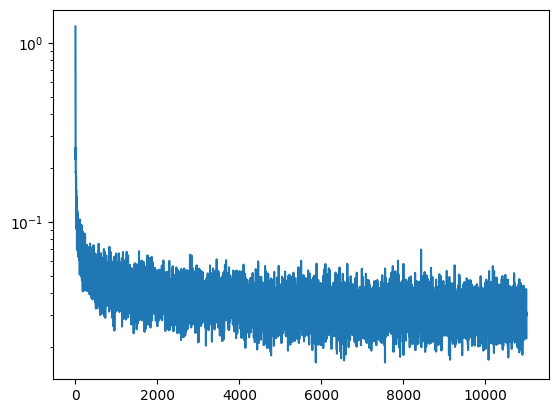

In [6]:
from diffusers import UNet2DConditionModel, UNet2DModel

model_unconditional = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1,            # the number of input channels
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    ).to(device)


model_unconditional, losses = train(
    model=model_unconditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=True,
    train_dataloader=train_dataloader, noise_scheduler=noise_scheduler
    )

plt.plot(losses)
plt.yscale('log')

plt.show()

Once training finishes, we can sample some images feeding in different labels as our conditioning:

In [ ]:
def sample(model, n_samples, noise_shape, conditioning, noise_scheduler, plot_last_steps):

    # device = model.device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare random x to start from, plus some desired labels y
    x = torch.randn(n_samples, 1, noise_shape, noise_shape).to(device)      
        
    # Sampling loop
    for i, t in tqdm(enumerate(noise_scheduler.timesteps), total=noise_scheduler.config.num_train_timesteps):

        # Get model pred
        with torch.no_grad():
            if conditioning is None:
                residual = model(x, t).sample
            else:
                residual = model(x, t,
                                 conditioning=conditioning.to(device)
                                 ).sample

        # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample
        
        if plot_last_steps and i > 900 and i % 10 == 0:
            plt.imshow(x[0][0].cpu().numpy())
            plt.show()
        
    return x

  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:46<00:00,  6.00it/s]


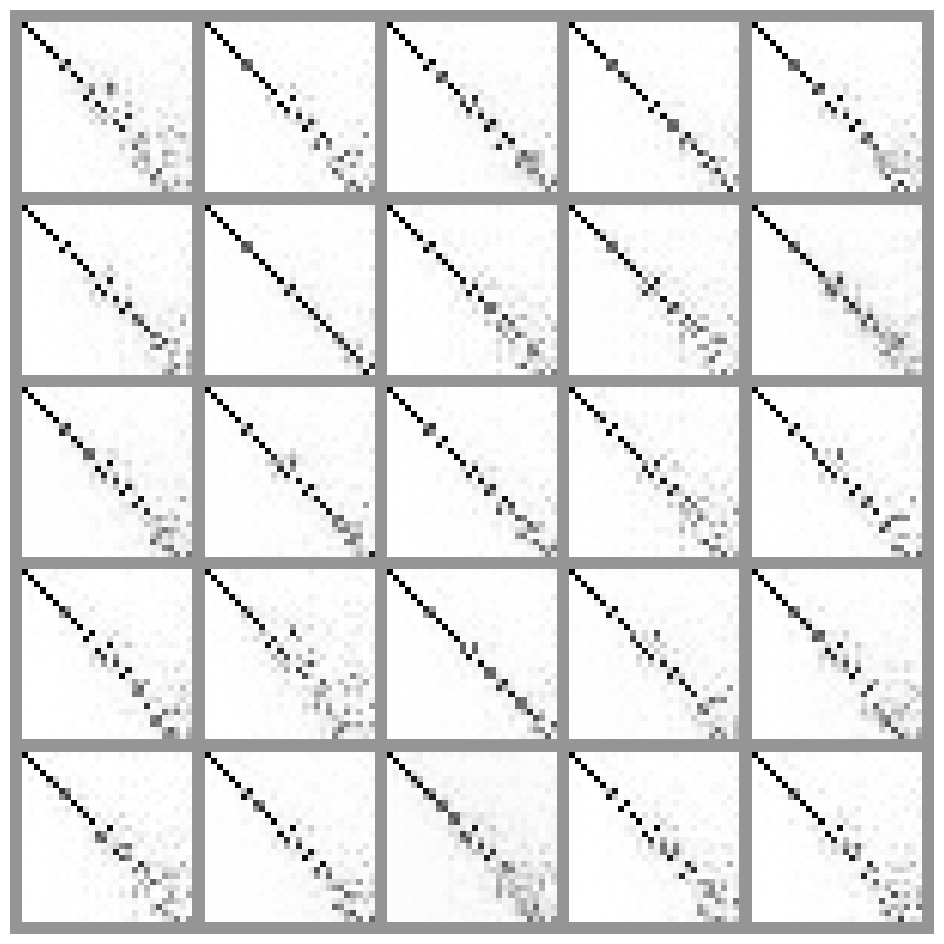

In [14]:
x_uncond = sample(
    model=model_unconditional,
    n_samples=1024,
    noise_shape=28,
    conditioning=None,
    noise_scheduler=noise_scheduler,
    plot_last_steps=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax_plot = ax.imshow(torchvision.utils.make_grid(
    x_uncond[:25].detach().cpu(), nrow=5, value_range=(-1, 1)#, scale_each=True
    )[0], cmap='Greys')
# plt.colorbar(ax_plot, ax=ax)

ax.axis('off')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax_0 = ax[0].imshow(test_dataset[3][0][0].numpy(), cmap='Greys')
# add colorbar
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_uncond[5][0].cpu().numpy(), cmap='Greys')
fig.colorbar(ax_1, ax=ax[1])

In [ ]:
def count_zero_regions(x_sampled, threshold, percentage):
    incorrect_zero_indices = []
    
    for i in range(x_sampled.shape[0]):
        if (x_sampled[i] > threshold).int().sum() > percentage * x_sampled[i].numel():
            incorrect_zero_indices.append(i)
            
    print(f'Incorrect zero regions: {len(incorrect_zero_indices)} / {x_sampled.shape[0]} = '
          f'{len(incorrect_zero_indices) / x_sampled.shape[0]*100:.2f}%')
    
    return incorrect_zero_indices

In [8]:

inc_inx = count_zero_regions(x_uncond, -0.7, 0.2)

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax_0 = ax[0].imshow(x_uncond[inc_inx[0]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
# fig.colorbar(ax_0, ax=ax[0])

# ax_1 = ax[1].imshow(x_uncond[inc_inx[1]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
# fig.colorbar(ax_1, ax=ax[1])

# plt.show()

Incorrect zero regions: 1 / 256 = 0.39%


# Conditional model

  0%|                                                                                                                           | 0/25 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [14:19<00:00, 34.40s/it, avg_loss=0.027]


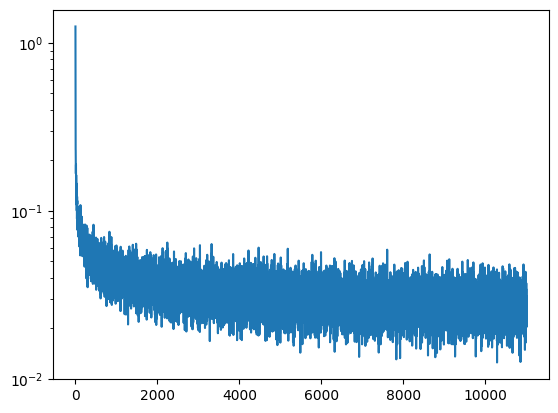

In [7]:
from diffusers import UNet2DConditionModel

class EncoderConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = UNet2DConditionModel(
            sample_size=28,           # the target image resolution
            in_channels=1, # Additional input channels for class cond.
            out_channels=1,           # the number of output channels
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
              ),
            encoder_hid_dim=28,
        ).to(device)
    
  def forward(self, sample, timestep, conditioning):
    return self.model(sample, timestep, encoder_hidden_states=conditioning)

model_encoder_conditional = EncoderConditionedUnet().to(device)

model_encoder_conditional, losses_encoder_cond = train_model.train(
    model=model_encoder_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False,
    train_dataloader=train_dataloader, noise_scheduler=noise_scheduler
    )

plt.plot(losses_encoder_cond)
plt.yscale('log')

plt.show()

In [20]:
import importlib
importlib.reload(sample_model)

<module 'my_code.diffusion_training.sample_model' from '/home/s94zalek/shape_matching/my_code/diffusion_training/sample_model.py'>

Sampling 1024 random fmaps


  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:49<00:00,  5.91it/s]


Sum across image
Loss sum: 13517.0928, mean: 13.2003
Random loss sum: 45645.6406, mean: 44.5758
Divided by nonzero count
Loss sum: 72.8451, mean: 0.0711
Random loss sum: 251.1734, mean: 0.2453


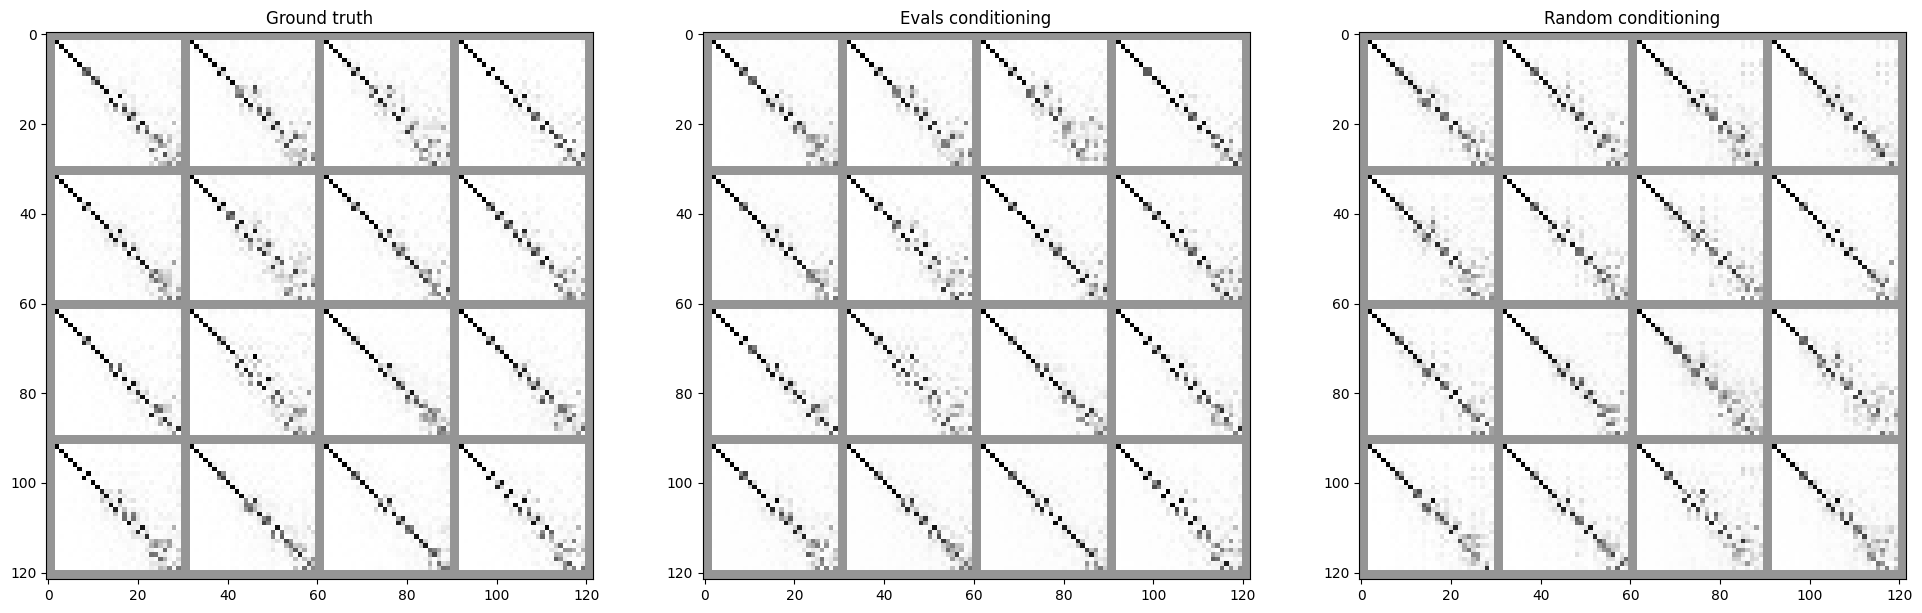

In [50]:
def conditional_loss(x_gt, x_cond, x_rand_cond):
    loss_eval = torch.tensor([])
    loss_random = torch.tensor([])
    nonzero_counts = torch.tensor([])

    for i in range(len(x_cond)):
        gt_fmap = x_gt[i][0]
        pred_fmap = x_cond[i][0]
        pred_fmap_rand = x_rand_cond[i][0]
        
        nonzero_count = (gt_fmap > -0.9).int().sum()
        nonzero_counts = torch.cat((nonzero_counts, nonzero_count.view(1)))
        
        loss_fmap = (gt_fmap - pred_fmap).abs().square().sum()
        loss_fmap_rand = (gt_fmap - pred_fmap_rand).abs().square().sum()
        
        loss_eval = torch.cat((loss_eval, loss_fmap.view(1)))
        loss_random = torch.cat((loss_random, loss_fmap_rand.view(1)))
        
    print(f'Sum across image')
    print(f'Loss sum: {torch.sum(loss_eval):.4f}, mean: {torch.mean(loss_eval):.4f}')
    print(f'Random loss sum: {torch.sum(loss_random):.4f}, mean: {torch.mean(loss_random):.4f}')
    
    print(f'Divided by nonzero count')
    print(f'Loss sum: {torch.sum(loss_eval / nonzero_counts):.4f}, mean: {torch.mean(loss_eval / nonzero_counts):.4f}')
    print(f'Random loss sum: {torch.sum(loss_random / nonzero_counts):.4f}, mean: {torch.mean(loss_random / nonzero_counts):.4f}')
    


def conditional_sampling(model, rand_indices):

    print(f"Sampling {len(rand_indices)} random fmaps")

    x_gt = torch.stack([test_dataset[i][0] for i in rand_indices])
    y_gt = torch.stack([test_dataset[i][1] for i in rand_indices])
    y_rand = torch.randn_like(y_gt)

    x_cond = sample_model.sample(model, len(rand_indices), conditioning=y_gt, plot_last_steps=False,
                                 noise_scheduler=noise_scheduler, noise_shape=28).detach().cpu()
    
    x_rand_cond = sample_model.sample(model, len(rand_indices), conditioning=y_rand, plot_last_steps=False,
                                      noise_scheduler=noise_scheduler, noise_shape=28).detach().cpu()


    conditional_loss(x_gt, x_cond, x_rand_cond)



    fig, ax = plt.subplots(1, 3, figsize=(24, 8))

    ax_0 = ax[0].imshow(torchvision.utils.make_grid(
        x_gt[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[0].set_title('Ground truth')

    ax_1 = ax[1].imshow(torchvision.utils.make_grid(
        x_cond[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[1].set_title('Evals conditioning')

    ax_2 = ax[2].imshow(torchvision.utils.make_grid(
        x_rand_cond[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[2].set_title('Random conditioning')

    plt.show()
    
    return x_gt, x_cond, x_rand_cond
    
    
rand_indices = np.random.choice(len(test_dataset), 1024, replace=False)
x_gt, x_cond_encoder, x_rand_cond = conditional_sampling(model_encoder_conditional, rand_indices)

In [53]:
conditional_loss(x_gt, x_cond_encoder, x_uncond.detach().cpu())

Sum across image
Loss sum: 13517.0928, mean: 13.2003
Random loss sum: 47601.1445, mean: 46.4855
Divided by nonzero count
Loss sum: 72.8451, mean: 0.0711
Random loss sum: 259.0996, mean: 0.2530


In [ ]:
max_loss = torch.argmax(losses_encoder_cond)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax_0 = ax[0].imshow(x_gt[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_cond_encoder[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(x_rand_cond[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_2, ax=ax[2])

plt.show()

In [ ]:
inc_inx = count_zero_regions(x_cond, -0.7, 0.2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rand_idx = np.random.choice(inc_inx, 3, replace=False)

ax_0 = ax[0].imshow(x_cond[rand_idx[0]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_cond[rand_idx[1]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(x_cond[rand_idx[2]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_2, ax=ax[2])

plt.show()

In [40]:
def plot_sampling_difference(x_gt, x_cond, idx):
    
        
    fig, ax = plt.subplots(3, 3, figsize=(10, 8))

    for i in range(3):
        
        nonzero_count = (x_gt[idx[i]][0] > -0.9).int().sum()
        
        ax[i, 0].imshow(x_gt[idx[i]][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
        ax[i, 0].set_title('Ground truth')
        
        ax[i, 1].imshow(x_cond[idx[i]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
        ax[i, 1].set_title('Evals conditioning')
        
        difference = x_gt[idx[i]][0] - x_cond[idx[i]][0].cpu()
        ax_2 = ax[i, 2].imshow(difference.abs().numpy(),
                        cmap='Greys', vmin=0)
        plt.colorbar(ax_2, ax=ax[i, 2])
        
        ax[i, 2].set_title(f'Difference {difference.min():.2f} {difference.max():.2f}, {difference.abs().sum() / nonzero_count:.2f}, {difference.abs().sum():.2f}')
        
        # set suptitle 
        
        
    plt.show()

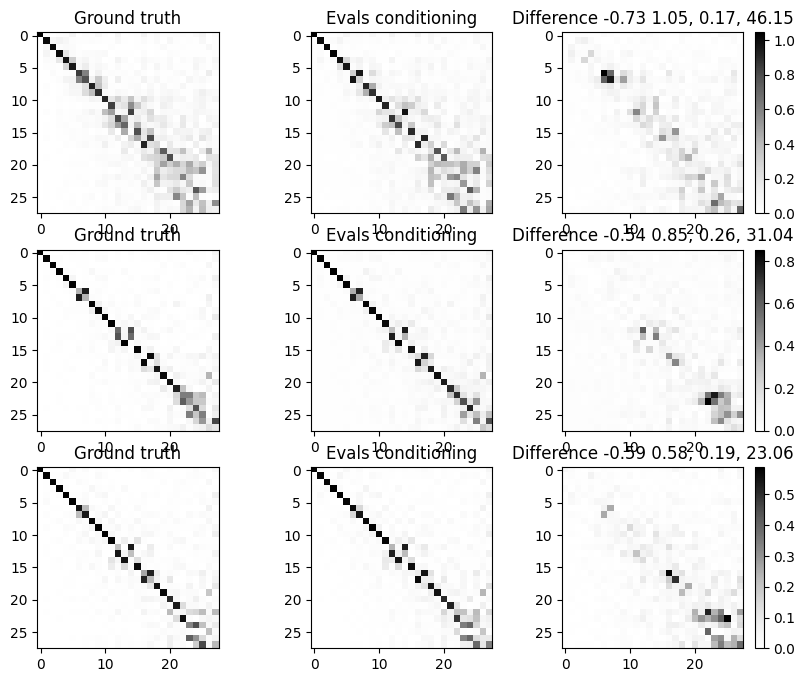

In [42]:
rand_idx = np.random.choice(len(x_gt), 3, replace=False)
plot_sampling_difference(x_gt, x_cond_encoder, rand_idx)

# Conditioning through concatenation

  0%|                                                                                                                           | 0/25 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [14:05<00:00, 33.82s/it, avg_loss=0.0273]


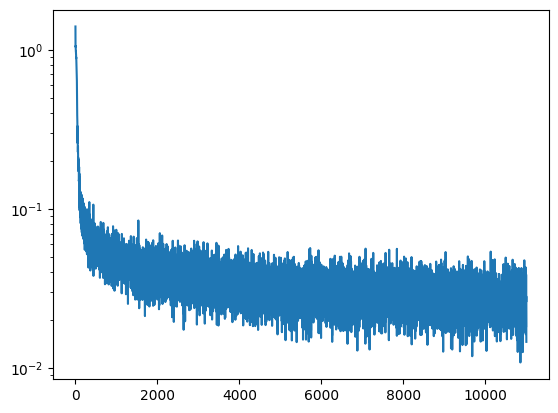

In [8]:
class DiagConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=2, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, sample, timestep, conditioning):

    conditioning_diag = torch.diag_embed(conditioning) # (bs, 28, 28

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((sample, conditioning_diag), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, timestep) # (bs, 1, 28, 28)
  
  
model_diag_conditional = DiagConditionedUnet().to(device)

model_diag_conditional, losses_diag_cond = train_model.train(
    model=model_diag_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False,
    train_dataloader=train_dataloader, noise_scheduler=noise_scheduler
    )

plt.plot(losses_diag_cond)
plt.yscale('log')

plt.show()
  

In [52]:
# x_gt, x_cond_diag, x_rand_cond_diag = conditional_sampling(model_diag_conditional, rand_indices)
conditional_loss(x_gt, x_cond_diag, x_uncond.detach().cpu())

Sum across image
Loss sum: 9689.8115, mean: 9.4627
Random loss sum: 47601.1445, mean: 46.4855
Divided by nonzero count
Loss sum: 52.1158, mean: 0.0509
Random loss sum: 259.0996, mean: 0.2530


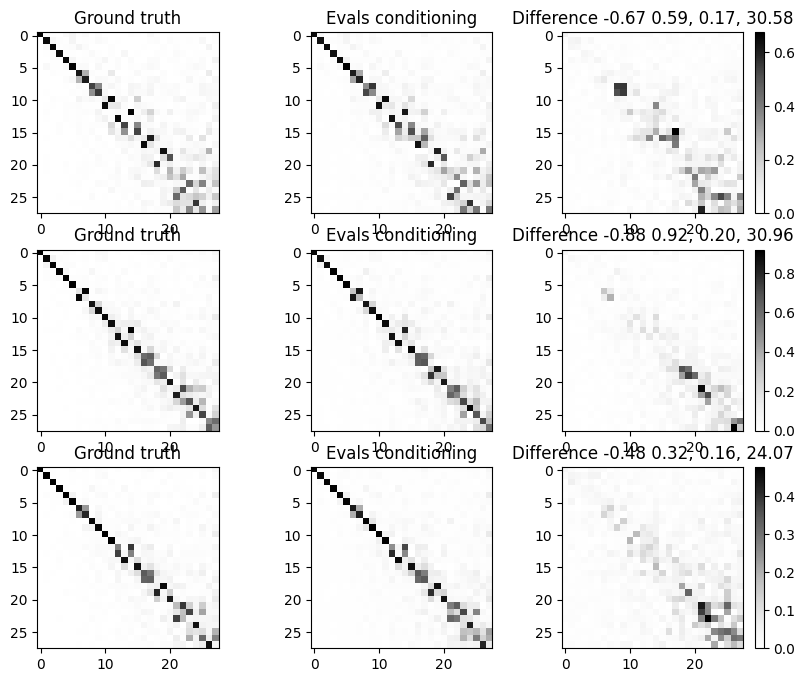

In [49]:
plot_sampling_difference(x_gt, x_cond_diag, rand_idx)